# Detecção de Árvores em Imagens

Este notebook implementa um modelo de deep learning utilizando a arquitetura MobileNetV2 como base para detectar e prever bounding boxes em árvores. O objetivo é prever as coordenadas dos limites (bounding boxes) das árvores nas imagens fornecidas.

## 1. Importação e Configuração de Dependências

Iniciamos instalando e importando as bibliotecas necessárias, incluindo TensorFlow, RoboFlow e outras utilidades para manipulação de imagens e visualização de resultados.

In [ ]:
!pip install tensorflow tensorflow-lite
!pip install roboflow

ERROR: Could not find a version that satisfies the requirement tensorflow-lite (from versions: none)
ERROR: No matching distribution found for tensorflow-lite
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from roboflow import Roboflow
import numpy as np
import os
import glob
from PIL import Image
import zipfile
import matplotlib.pyplot as plt

## 2. Preparação do Dataset

As imagens e as anotações são descompactadas e carregadas no formato necessário para o treinamento do modelo. Em seguida, um pipeline é criado para processar as imagens e os rótulos (labels) e dividir o dataset em conjuntos de treino e validação.

    - load_image: Função para carregar e redimensionar imagens.
    - load_annotation: Função para carregar as anotações de bounding boxes.
    - load_dataset: Função para carregar o dataset e dividi-lo entre treino e validação.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Annotations2.zip to Annotations2.zip


In [ ]:
# Descompacte o arquivo
zip_file = "Images2.zip"  # substitua com o nome do seu arquivo
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("images")  # Substitua "images" pelo nome da pasta de destino


In [ ]:
# Descompacte o arquivo
zip_file = "Annotations2.zip"  # substitua com o nome do seu arquivo
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("annotations")  # Substitua "anotations" pelo nome da pasta de destino

In [ ]:
# Configurações iniciais
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
# Parsear e preparar o dataset para treinamento
def parse_tfrecord_fn(example):
    feature_description = {
        'images/encoded': tf.io.FixedLenFeature([], tf.string),
        'images/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    return tf.io.parse_single_example(example, feature_description)

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image

def load_annotation(annotation_path):
    with open(annotation_path, 'r') as file:
        boxes = []
        for line in file:
            parts = line.strip().split()
            xmin, ymin, xmax, ymax = map(float, parts[1:])
            boxes.append([xmin, ymin, xmax, ymax])
        return np.array(boxes, dtype=np.float32)

def load_dataset(image_dir, annotation_dir, batch_size=32, validation_split=0.2):
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))
    annotation_paths = [os.path.join(annotation_dir, os.path.splitext(os.path.basename(path))[0] + '.txt') for path in image_paths]

    if not image_paths:
        raise ValueError("Nenhuma imagem encontrada no diretório especificado.")

    images = []
    labels = []
    for image_path, annotation_path in zip(image_paths, annotation_paths):
        image = load_image(image_path)
        if os.path.exists(annotation_path):
            annotation = load_annotation(annotation_path)
            if annotation.shape[0] > 0:
                labels.append(annotation[0])  # Assume que há um único objeto por imagem
            else:
                labels.append([0, 0, 0, 0])
        else:
            labels.append([0, 0, 0, 0])
        images.append(image)

    images = np.array(images)
    labels = np.array(labels, dtype=np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset_size = len(images)
    val_size = int(validation_split * dataset_size)
    train_size = dataset_size - val_size

    train_dataset = dataset.take(train_size).shuffle(train_size).batch(batch_size)
    val_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, val_dataset

# Defina o diretório onde as imagens estão armazenadas
image_dir = "images/Images2"  # Substitua pelo caminho do seu diretório de imagens
annotation_dir = "annotations/Annotations2"

# Carregue os datasets de treino e validação
train_dataset, val_dataset = load_dataset(image_dir, annotation_dir)


## 3. Construção do Modelo

Utilizamos a arquitetura MobileNetV2 como base (backbone) para o nosso modelo, devido à sua eficiência e desempenho em tarefas de visão computacional.

- O modelo foi modificado para incluir camadas adicionais que prevêem as coordenadas das bounding boxes.
- Compilação: O modelo foi compilado com a função de perda mean squared error e a métrica mean absolute error.

In [ ]:
# Construir o modelo usando MobileNetV2 como backbone
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Construir o cabeçalho do modelo para prever bounding boxes
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4)  # Saída para bounding boxes [xmin, ymin, xmax, ymax]
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 4. Treinamento

O modelo foi treinado por 50 épocas usando o dataset de treino, e os resultados foram validados em cada época usando o conjunto de validação.

In [ ]:
# Treinar o modelo
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 229300.5938 - mae: 462.7440 - val_loss: 192597.0156 - val_mae: 423.6882
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 223106.6562 - mae: 456.6046 - val_loss: 186504.2500 - val_mae: 416.4936
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 211787.9688 - mae: 444.6380 - val_loss: 179626.2812 - val_mae: 408.2033
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 205310.7812 - mae: 437.4217 - val_loss: 171953.5312 - val_mae: 398.7298
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 198217.2188 - mae: 429.6581 - val_loss: 163511.0938 - val_mae: 388.0107
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 182589.2188 - mae: 409.7263 - val_loss: 154358.4688 - val_mae: 376.0114
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 177102.8750 - mae: 405.0401 - val_loss: 144507.9531 - val_mae: 362.6125
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 162160.6094 - mae: 385.9810 - val_loss: 134056.7188 - v

## 5. Avaliação e Visualização

Os resultados do treinamento foram visualizados em termos de Loss e MAE (Mean Absolute Error), mostrando a evolução do modelo durante o processo de aprendizado.
Predição em uma Imagem de Teste

- Uma imagem do conjunto de validação foi utilizada para prever a bounding box e compará-la com a anotação real.
- Funções para denormalizar: As coordenadas preditas e verdadeiras foram convertidas de volta para o formato original da imagem para visualização.


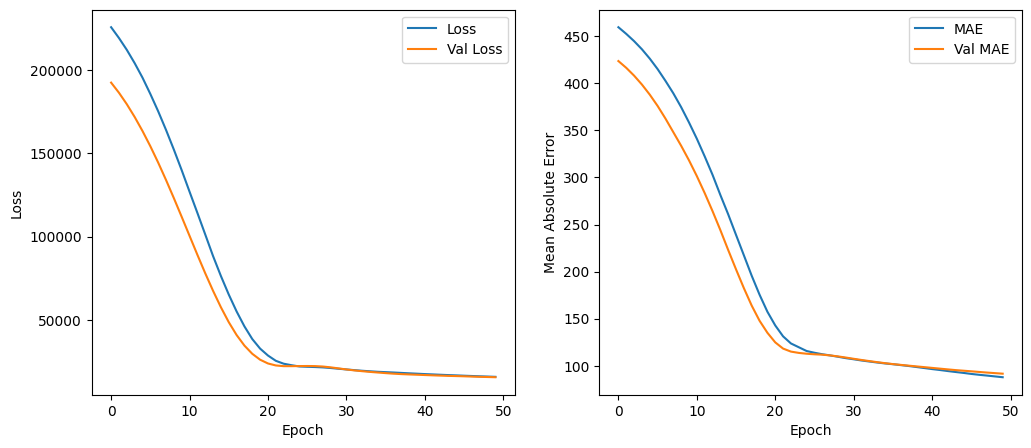

In [ ]:
# Plotar o histórico de treinamento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


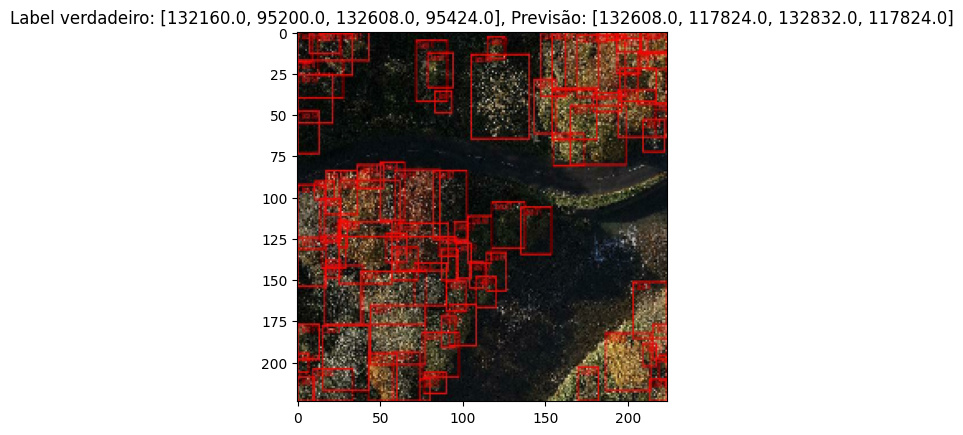

In [ ]:
# Pegando uma imagem de teste do dataset
for images, labels in val_dataset.take(1):
    sample_image = images[0].numpy()
    sample_label = labels[0].numpy()

# Expandindo as dimensões para modelar a previsão
sample_image_expanded = np.expand_dims(sample_image, axis=0)

# Gerando a previsão
prediction = model.predict(sample_image_expanded)

# Convertendo as coordenadas da previsão e do rótulo de volta ao formato original
def denormalize_box(box, img_size):
    xmin, ymin, xmax, ymax = box
    return [xmin * img_size, ymin * img_size, xmax * img_size, ymax * img_size]

# Desnormalizando os valores
sample_label_denorm = denormalize_box(sample_label, IMG_SIZE)
prediction_denorm = denormalize_box(np.round(prediction[0]), IMG_SIZE)

# Exibindo a imagem e a previsão
plt.imshow(sample_image)
plt.title(f'Label verdadeiro: {sample_label_denorm}, Previsão: {prediction_denorm}')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Precisão: 0.00%
Recall: 0.00%


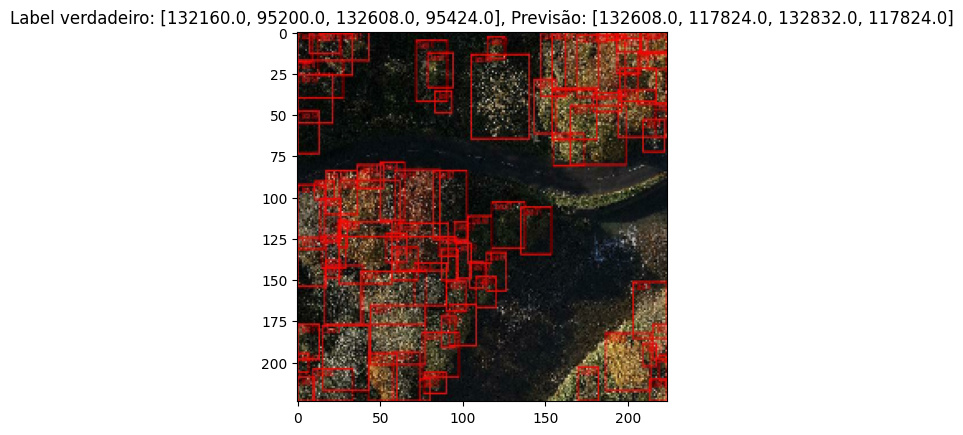

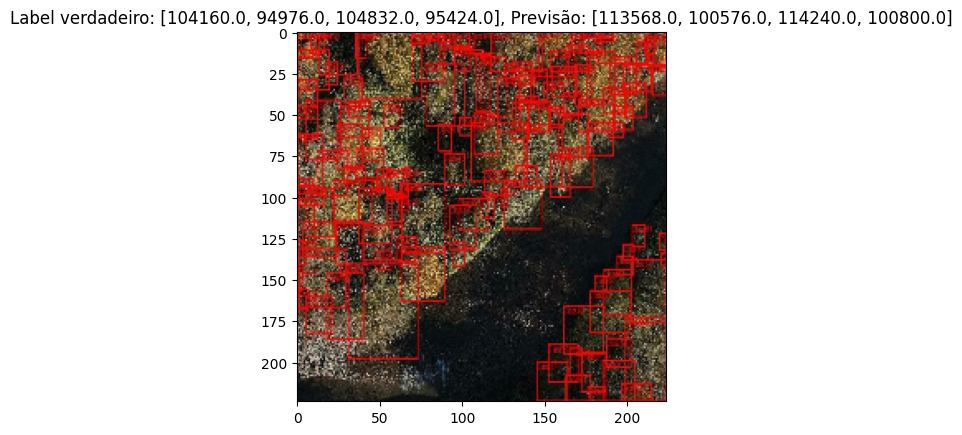

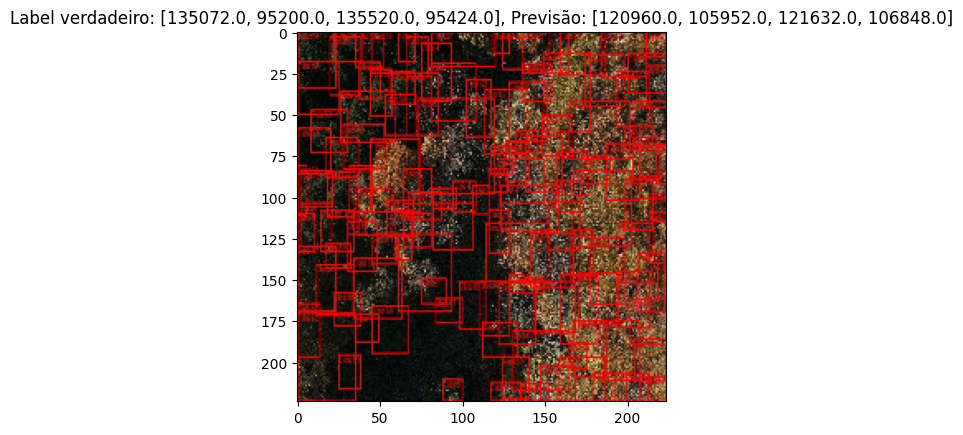

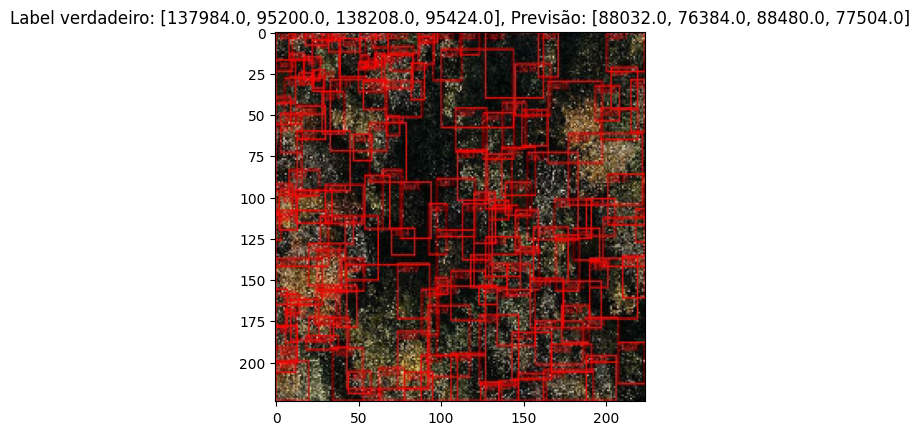

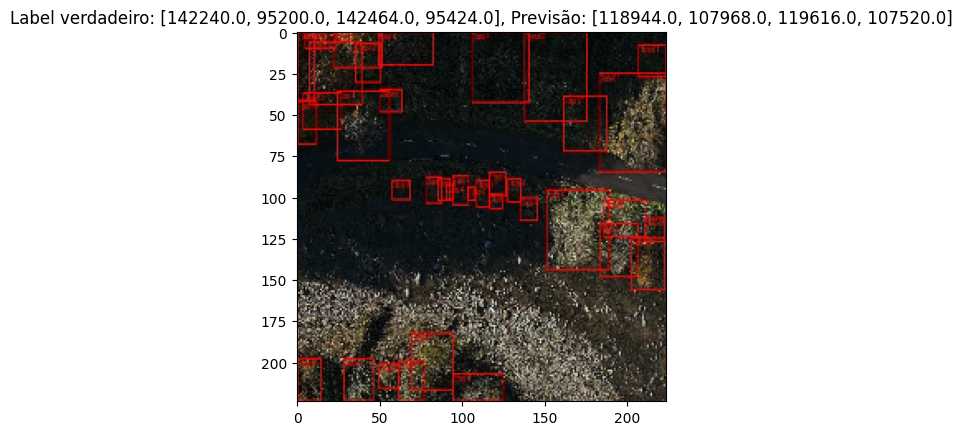

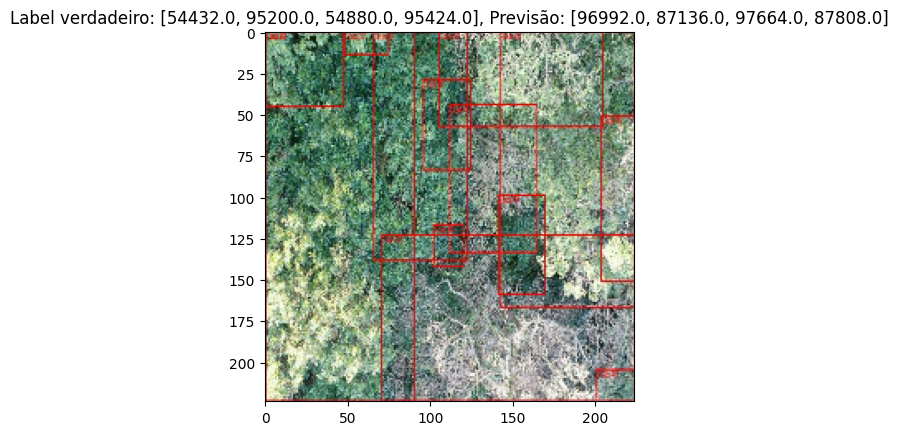

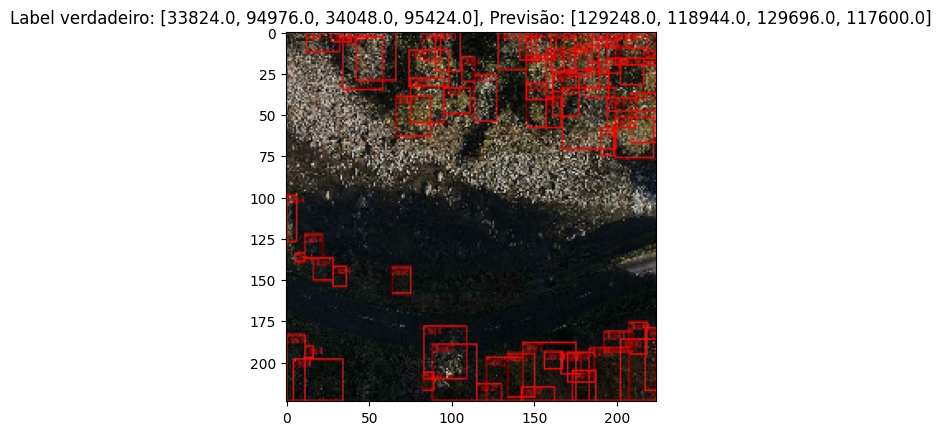

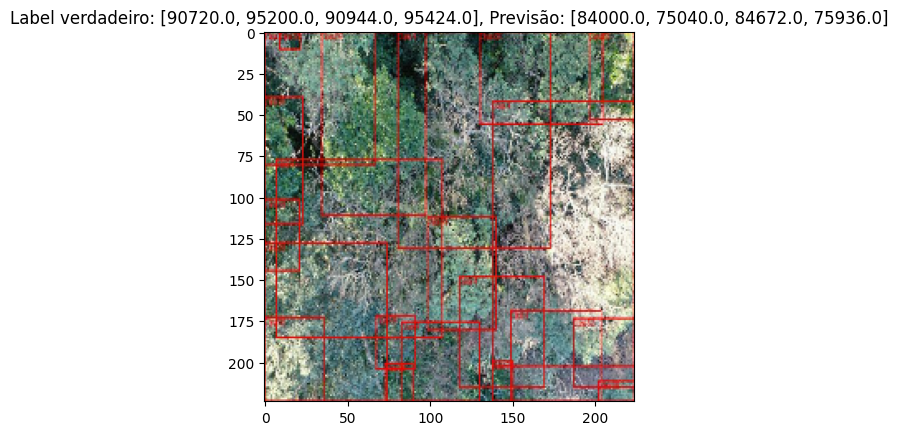

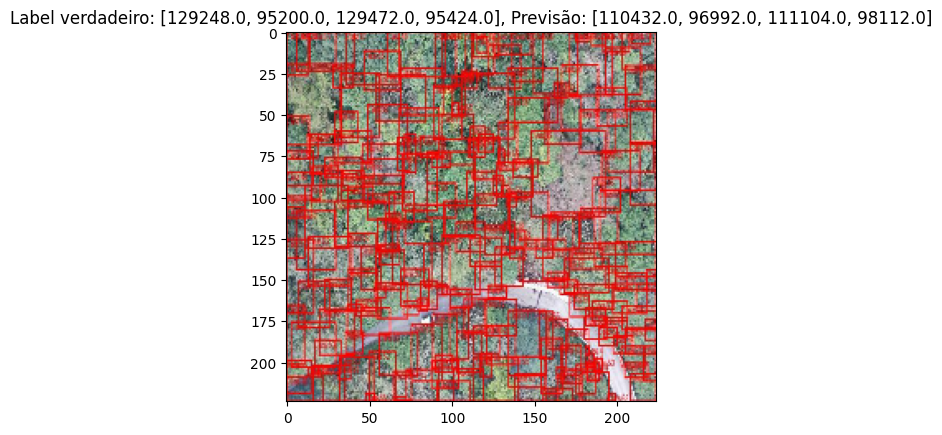

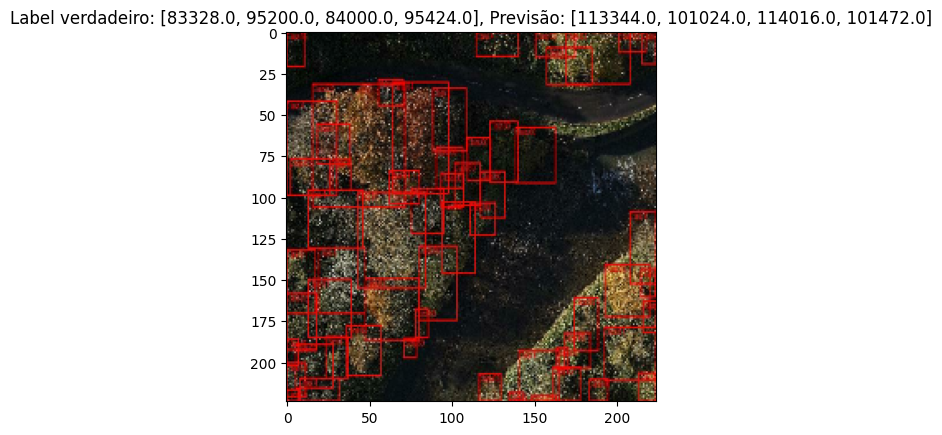

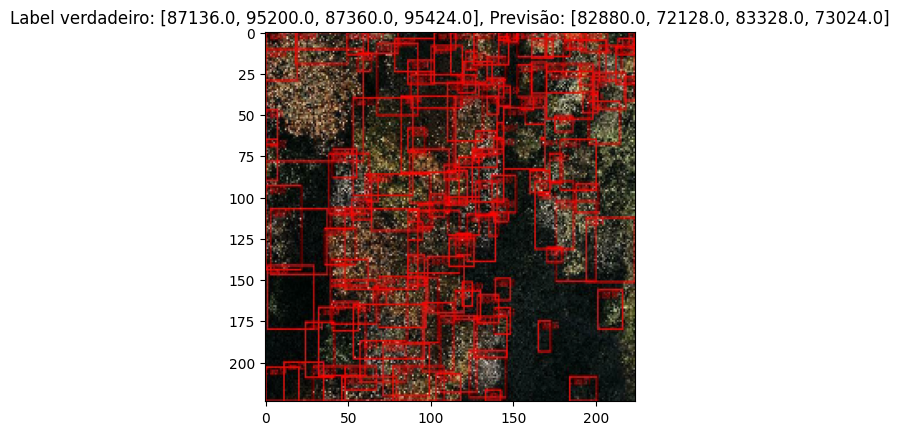

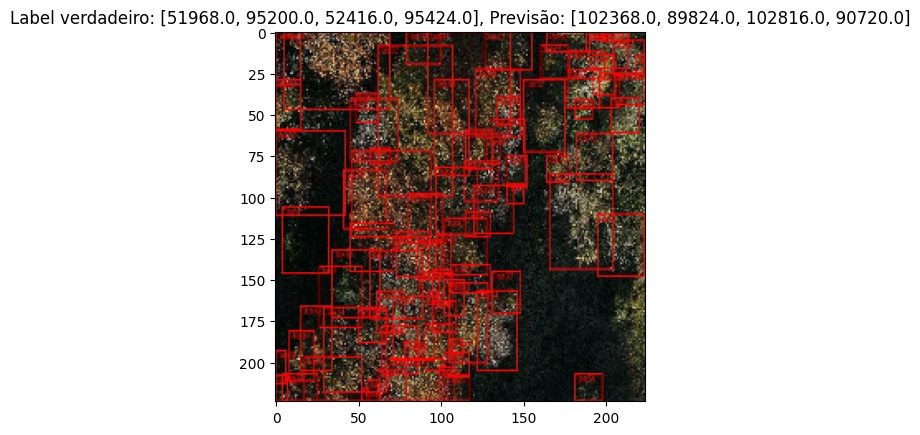

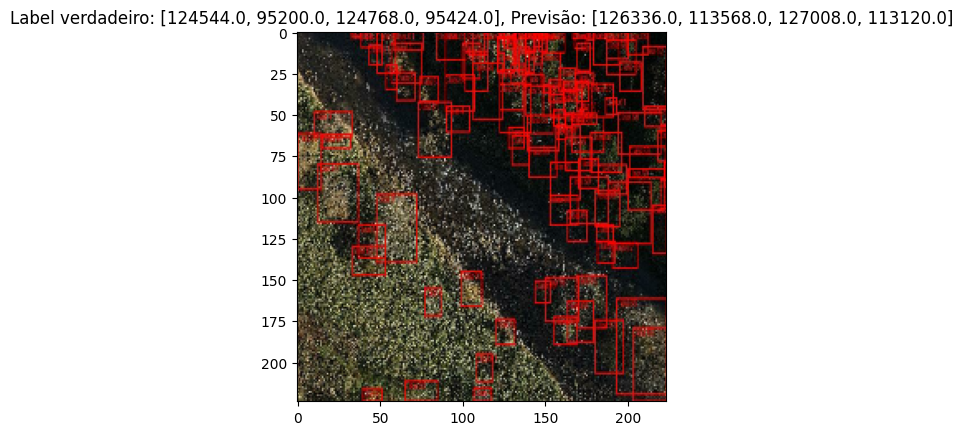

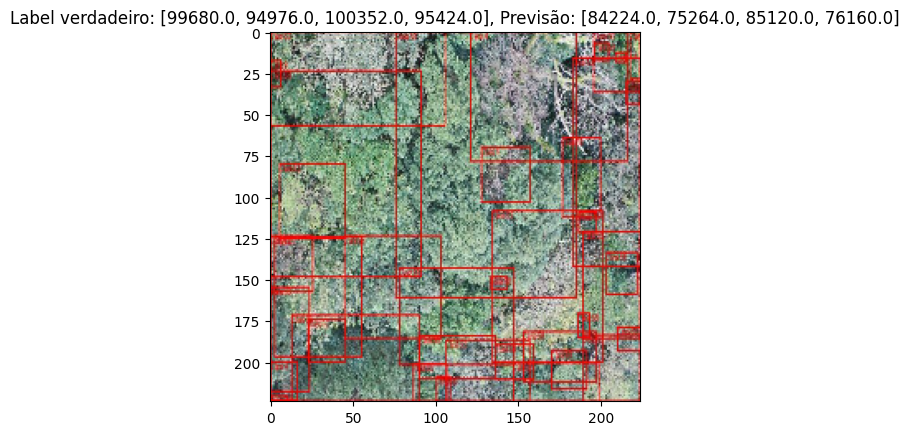

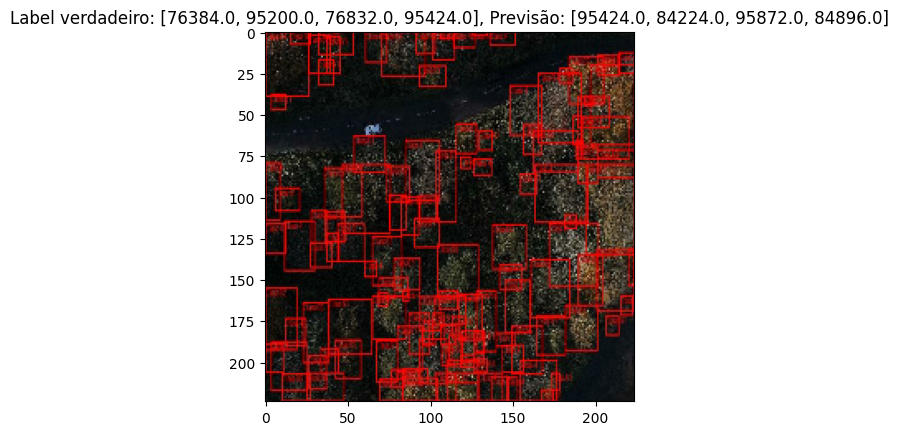

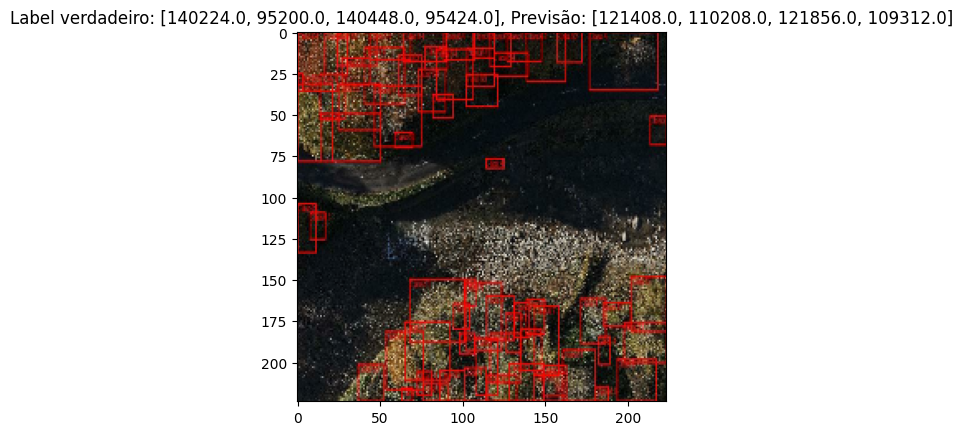

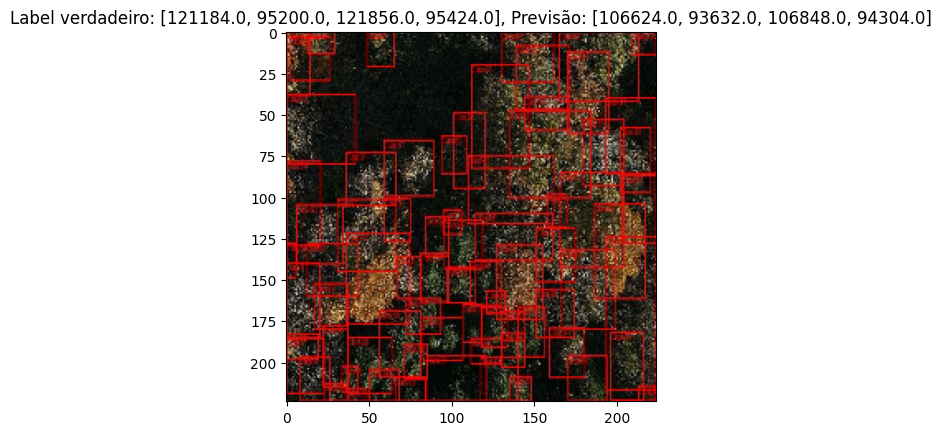

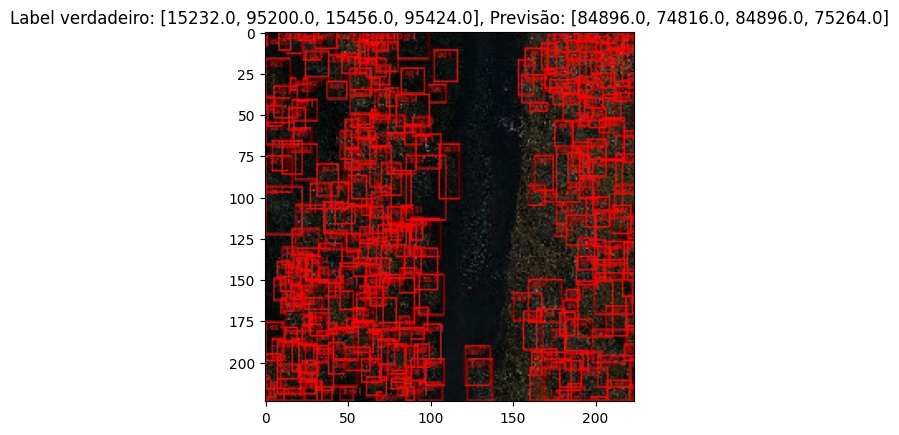

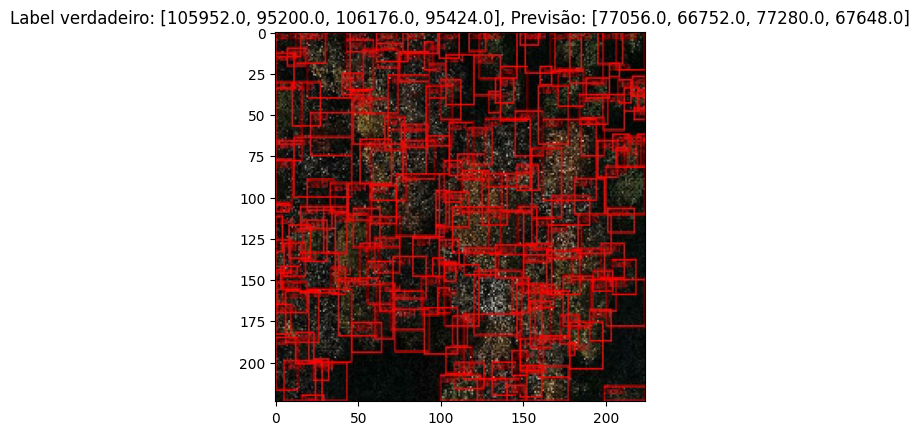

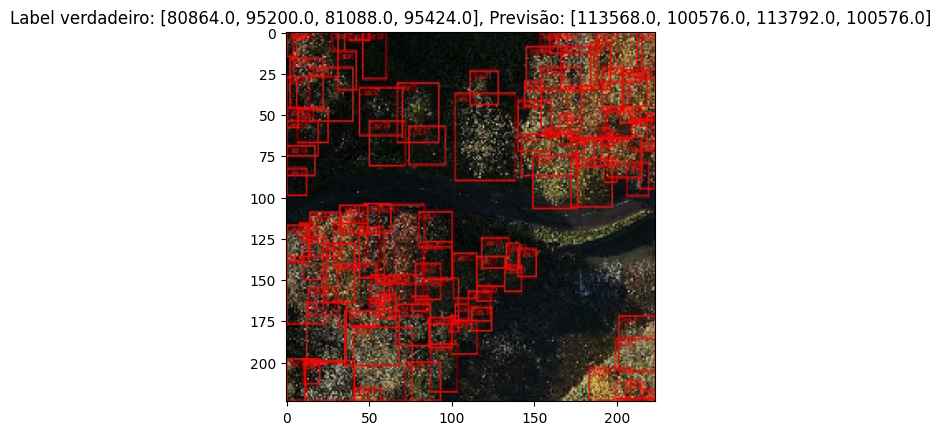

Acurácia (IoU > 0.5): 0.00%


In [ ]:
# Função para calcular IoU (Intersection over Union)
def calculate_iou(box1, box2):
    # box format: [xmin, ymin, xmax, ymax]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union != 0 else 0

# Função para calcular precisão baseada em IoU
def calculate_precision_recall(predictions, labels, iou_threshold=0.5):
    precisions = []
    recalls = []

    for pred_box, true_box in zip(predictions, labels):
        iou = calculate_iou(pred_box, true_box)
        if iou >= iou_threshold:
            precisions.append(1)
            recalls.append(1)
        else:
            precisions.append(0)
            recalls.append(0)

    precision = np.mean(precisions)  # Precisão média
    recall = np.mean(recalls)  # Recall médio

    return precision, recall

# Pegando um batch de validação para cálculo
for images, labels in val_dataset.take(1):
    predictions = model.predict(images)

# Desnormalizar bounding boxes
def denormalize_boxes(boxes, img_size):
    denormalized_boxes = []
    for box in boxes:
        denormalized_box = denormalize_box(box, img_size)
        denormalized_boxes.append(denormalized_box)
    return denormalized_boxes

# Convertendo as previsões e os rótulos para o formato original
labels_denorm = denormalize_boxes(labels.numpy(), IMG_SIZE)
predictions_denorm = denormalize_boxes(np.round(predictions), IMG_SIZE)

# Calcular precisão e recall
precision, recall = calculate_precision_recall(predictions_denorm, labels_denorm)

# Imprimindo os resultados
print(f"Precisão: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

# Exibindo a imagem com a previsão e o rótulo verdadeiro
for i in range(len(images)):
    plt.imshow(images[i].numpy())
    plt.title(f'Label verdadeiro: {labels_denorm[i]}, Previsão: {predictions_denorm[i]}')
    plt.show()

# Acurácia baseada em IoU com threshold de 0.5
iou_threshold = 0.5
accuracy = np.mean([calculate_iou(pred, label) >= iou_threshold for pred, label in zip(predictions_denorm, labels_denorm)])
print(f"Acurácia (IoU > {iou_threshold}): {accuracy * 100:.2f}%")
